In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from IPython.display import display, clear_output

from iarchitect import envs,trainer as trainer_iarch
from iarchitect.agents import dqn as dqn_iarch,ddpg as ddpg_iarch
from iarchitect.common import show_policy_behaviour
from tf_agents.agents import ddpg
from tf_agents.agents import DdpgAgent,DqnAgent


from tf_agents.utils import common
from tf_agents import networks
from tf_agents.networks import sequential
from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts
from tf_agents.metrics import py_metrics,tf_metrics
from tf_agents.drivers import py_driver,dynamic_episode_driver,dynamic_step_driver
from tf_agents.policies import random_py_policy,random_tf_policy,PyTFEagerPolicy
from tf_agents.replay_buffers import tf_uniform_replay_buffer,py_uniform_replay_buffer

from tensorflow import Tensor,Variable
from tensorflow.keras import layers,Input,Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras import initializers


2022-03-02 14:50:45.195117: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-02 14:50:45.195153: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



# Utils

## Utils

In [49]:
def show_agent_behavior(tf_env,agent,ax,axes):
    results = show_policy_behaviour(tf_env,trainer.agent.policy,50)
#     ax.plot([r[0] for r in results],label="action")
    ax.plot([r[1] for r in results],label="reward")
    n = min(len(results),len(axes))
    for ax_,res in zip(axes[:n],[r[2] for r in results[:n]]):
        ax_.imshow(res.reshape(res.shape[1:-1]))

## Plot

In [50]:
def update_plotter(r,c):
    assert r%3==0
    fig = plt.figure(figsize=(20,20))
    gs = GridSpec(r, c,width_ratios=[1,1]+[1/(c-2)]*(c-2))
    ax = fig.add_subplot(gs[0:r//3,0])
    ax2 = fig.add_subplot(gs[r//3:r//3*2,0])
    ax3 = fig.add_subplot(gs[r//3*2:,0])
    ax4 = fig.add_subplot(gs[:,1])
    import itertools
    axes =[fig.add_subplot(gs[i,j+2]) for i,j in itertools.product(range(r),range(c-2))]


    def update_plot(step,trainer):
        ax.clear()
        ax2.clear()
        ax3.clear()
        ax4.clear()
        for ax_ in axes:
            ax_.clear()
        ax.plot(trainer.metrics,label="metric",color="green")
        ax2.plot(trainer.losses,label="loss",color="red")
        trainer.observer.plot_reward(ax=ax3,slice_=slice(-50,None,None))
        show_agent_behavior(trainer.tf_env,trainer.agent,ax4,axes)
        ax.legend()
        ax2.legend()
        clear_output(wait = True)
        display(fig)
        
    return update_plot

# Examples

## 

In [16]:
environment = envs.TensorEnv(4,action_float=True,
                            fail_on_same=True,
                           rewards = {
                     "already_filled":-10,
                     "max_iter":-10,
                     "new_value":1,
                     "success":10
                 })
utils.validate_py_environment(environment, episodes=5)
train_env = tf_py_environment.TFPyEnvironment(environment)

In [17]:
from tf_agents.networks import sequential
def get_critic_0(obs_spec,action_spec):
    # Observation as input
    obs_in = Input(shape=obs_spec.shape+(1,))
    obs_out = layers.Conv2D(obs_spec.shape[0], (2,2), strides=(1,1), activation="relu")(obs_in)
    obs_out = layers.Conv2D(obs_spec.shape[0], (2,2), strides=(1,1), activation="relu")(obs_out)
    obs_out = layers.Flatten()(obs_out)
    

    # Action as input
    action_input = Input(shape=action_spec.shape)
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([obs_out, action_out])

    out = layers.Dense(10, activation="relu")(concat)
    out = layers.Dense(10, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = Model([obs_in, action_input], outputs)

    return model

In [18]:
def get_critic_1(obs_spec,action_spec):
    return ddpg.critic_network.CriticNetwork(
            (obs_spec, action_spec),
            observation_conv_layer_params=[(20,(2,2),(1,1))]*2,
            joint_fc_layer_params = [10]*2+[1]
            )

In [39]:
def get_critic_2(obs_spec,action_spec):
    print(obs_spec.shape[1])
    return ddpg.critic_network.CriticNetwork(
            (obs_spec, action_spec),
#             observation_fc_layer_params=[obs_spec.shape[1]]*5,
#             joint_fc_layer_params = [obs_spec.shape[1]]*5+[1]
        observation_fc_layer_params=[150,20],
            joint_fc_layer_params = [50]*2+[1]
            )

In [20]:
def get_actor_0(obs_spec,action_spec):
    # Observation as input
    obs_in = Input(shape=obs_spec.shape)
    obs_out = layers.Dense(32, activation="relu")(obs_in)
    obs_out = layers.Dense(32, activation="relu")(obs_out)
    obs_out = layers.Dense(action_spec.shape[0], activation="relu")(obs_out)
    model = Model(obs_in, obs_out)
    return model

In [21]:
def get_actor_1(observation_spec, action_spec):
    return ddpg.actor_network.ActorNetwork(
    observation_spec, action_spec,
    fc_layer_params=(100,50),
)


In [38]:
def get_actor_2(observation_spec, action_spec):
    return ddpg.actor_network.ActorNetwork(
    observation_spec, action_spec,
#     fc_layer_params=[observation_spec.shape[1]]*5,
    fc_layer_params=[150,50],
        
)

In [54]:
t = train_env.observation_spec(),train_env.action_spec()
agent = ddpg_iarch.agent_factory(
    train_env,
    actor_network=get_actor_2(*t),
    critic_network=get_critic_2(*t),
    learning_rate_actor=0.0005,
    learning_rate_critic=0.0005,
#     kwargs_agent = {"ou_stddev":0.5}
)

4


InvalidArgumentError: assertion failed: [TFUniformReplayBuffer is empty. Make sure to add items before sampling the buffer.] [Condition x > y did not hold element-wise:] [x (TFUniformReplayBuffer/get_next/SelectV2_1:0) = ] [0] [y (TFUniformReplayBuffer/get_next/SelectV2:0) = ] [0]
	 [[{{function_node TFUniformReplayBuffer_get_next_assert_greater_Assert_AssertGuard_false_41692878}}{{node TFUniformReplayBuffer/get_next/assert_greater/Assert/AssertGuard/Assert}}]] [Op:IteratorGetNext]

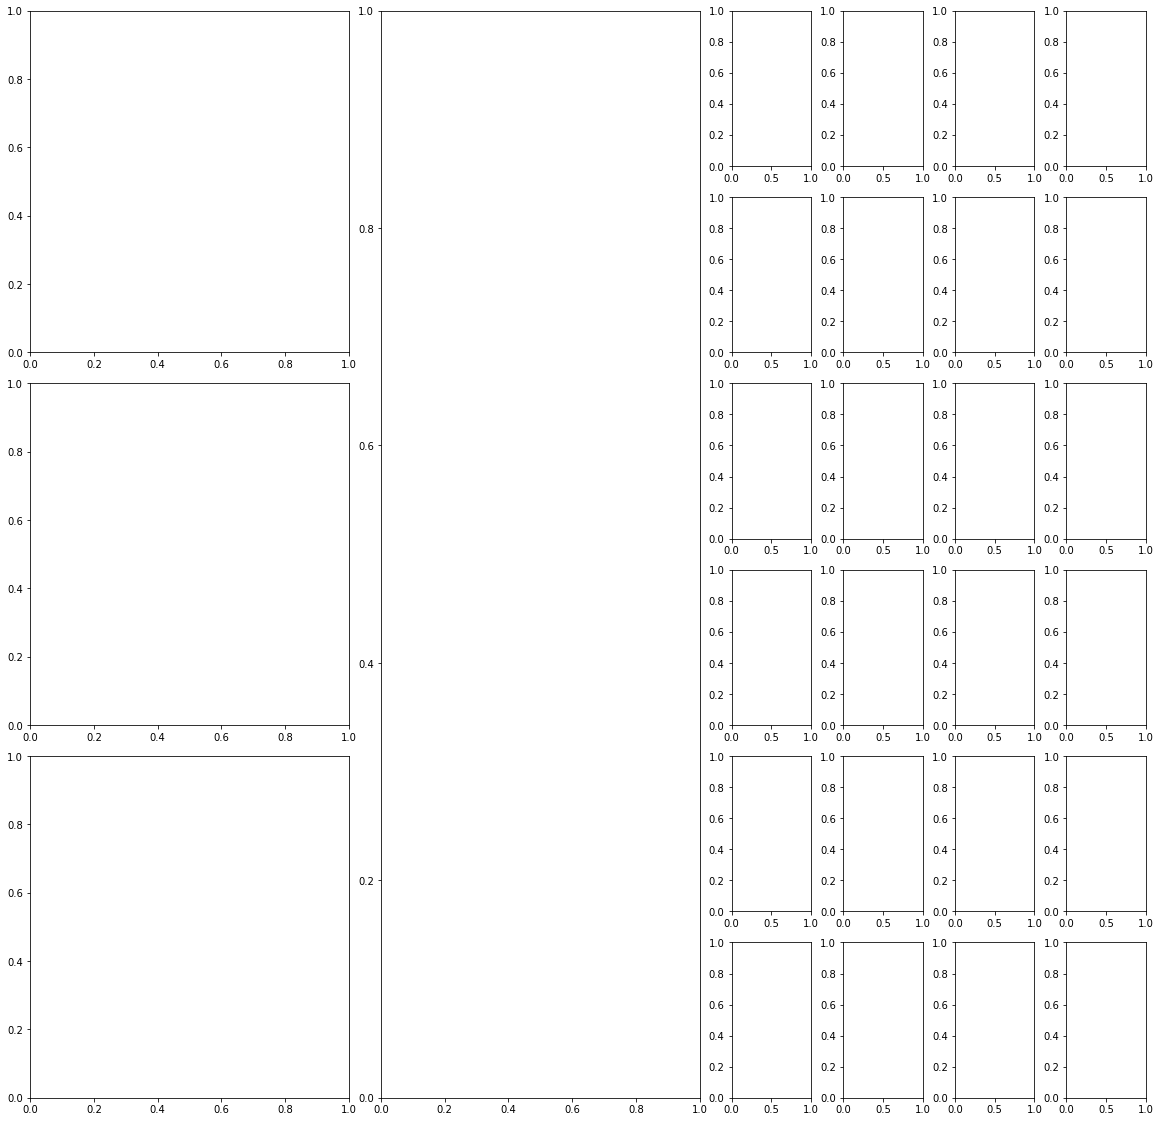

In [56]:
trainer = trainer_iarch.Trainer(train_env,agent)
trainer.run(callbacks=[update_plotter(6,6)],
            num_steps_collect_driver=1,
            sample_batch_size_experience = 64,
            num_iterations_train = 10,
            num_steps_per_row_in_experience = 2
           )

In [ ]:
trainer.agent._actor_network.summary()